# Animal Classification and Detection Demo

This notebook demonstrates an end-to-end pipeline that:
1. Uses a Named Entity Recognition (NER) model to extract animal names from text
2. Uses a Convolutional Neural Network (CNN) to classify animal images
3. Compares the two outputs to verify if the image contains the animal mentioned in the text

## Setup and Requirements

Before running this notebook, make sure to install the required packages:
 
# Install required packages (uncomment if needed)
# !pip install torch torchvision transformers Pillow scikit-learn matplotlib pandas numpy
 

In [1]:
import torch
from transformers import BertTokenizerFast, BertForTokenClassification
from torchvision import transforms, models
from PIL import Image
import os
import matplotlib.pyplot as plt

In [2]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Project Structure

The project consists of two main components:

1. **NER Model**: A BERT-based model trained to identify animal names in text
2. **CNN Model**: A ResNet18-based model trained to classify animal images

The models are trained to recognize the following 10 animal categories:
- butterfly
- cat
- chicken
- cow
- dog
- elephant
- horse
- sheep
- squirrel
- spider

## 1. Named Entity Recognition (NER) Model
This model extracts animal names from text. Let's define the functions to load and use the NER model:

In [8]:
def load_ner_model(model_path="NER_realization/NER_model"):
    """Load the NER model and tokenizer"""
    tokenizer = BertTokenizerFast.from_pretrained(model_path)
    model = BertForTokenClassification.from_pretrained(model_path)
    model.eval()
    id2tag = {0: "O", 1: "B-ANIMAL"}  # Label mapping
    return tokenizer, model, id2tag

def ner_predict(text, tokenizer, model, id2tag):
    """Extracts animal entities from text."""
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())
    predictions = outputs.logits.argmax(dim=2).squeeze().tolist()
    predicted_labels = [id2tag[pred] for pred in predictions]
    
    # Extract B-ANIMAL entities
    entities = [tokens[i] for i in range(len(tokens)) if predicted_labels[i] == "B-ANIMAL"]
    return entities


## 2. CNN Image Classification Model
This model classifies animal images. Let's define the functions to load and use the CNN model:

In [9]:
def load_cnn_model(model_path="CNN_realization/CNN_model/animal_classifier.pth"):
    """Load the trained CNN model"""
    checkpoint = torch.load(model_path, map_location=device)
    class_names = checkpoint['class_names']
    model = models.resnet18(weights='IMAGENET1K_V1')
    model.fc = torch.nn.Linear(model.fc.in_features, len(class_names))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model, class_names

def preprocess_image(image_path):
    """Preprocess the image for inference"""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)

def cnn_predict(image_path, model, class_names):
    """Predict the class of an image"""
    tensor_image = preprocess_image(image_path).to(device)
    with torch.no_grad():
        outputs = model(tensor_image)
        _, predicted = torch.max(outputs, 1)
    return class_names[predicted.item()]

## 3. Load Both Models

In [10]:
# Load NER model
tokenizer, ner_model, id2tag = load_ner_model()
# Load CNN model
cnn_model, class_names = load_cnn_model()

C:\Users\Joran\AppData\Local\Temp\ipykernel_45804\3567499157.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


## 4. Combined Pipeline Demo

In [16]:
def run_pipeline(text, image_path):
    """Run the full pipeline and display results"""
    
    extracted_animals = ner_predict(text, tokenizer, ner_model, id2tag)
    predicted_class = cnn_predict(image_path, cnn_model, class_names)
    match = predicted_class in extracted_animals
    print(f"Text: {text}")
    print(f"Extracted Animals: {extracted_animals}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Match Found: {match}")
    # Display image
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Predicted: {predicted_class}")
    plt.show()
    
    print(f"Text: {text}")
    print(f"Extracted Animals: {extracted_animals}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Match Found: {match}")
    return match
    return match

## 5. Test the Pipeline

Text: There is a dog in this picture.
Extracted Animals: ['dog', '[SEP]']
Predicted Class: cat
Match Found: False


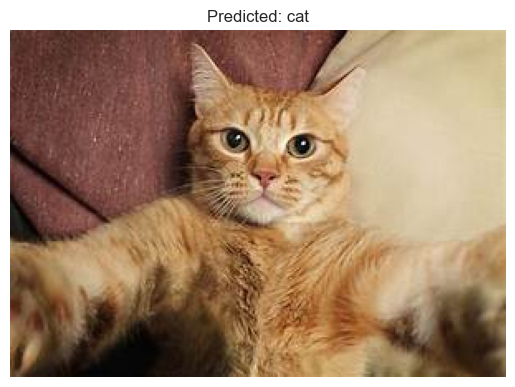

Text: There is a dog in this picture.
Extracted Animals: ['dog', '[SEP]']
Predicted Class: cat
Match Found: False


False

In [17]:
text = "There is a dog in this picture."
image_path = "CNN_realization/CNN_data/raw-img/cat/1.jpeg"
run_pipeline(text, image_path)

Text: I see a cat on a image
Extracted Animals: ['cat', '[SEP]']
Predicted Class: cat
Match Found: True


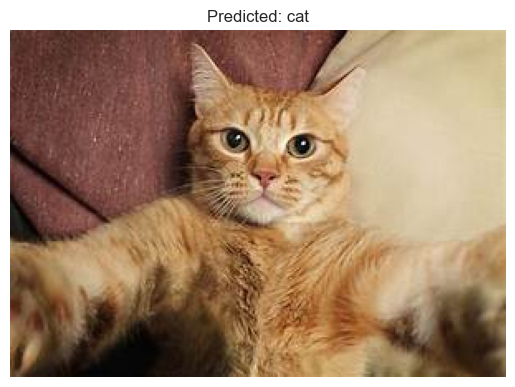

Text: I see a cat on a image
Extracted Animals: ['cat', '[SEP]']
Predicted Class: cat
Match Found: True


True

In [18]:
text = "I see a cat on a image"
image_path = "CNN_realization/CNN_data/raw-img/cat/1.jpeg"
run_pipeline(text, image_path)


## Conclusion
This notebook demonstrates a complete pipeline that:
- Extracts animal names from text using NER
- Classifies images using a CNN model
- Compares both results to verify correctness
